In [5]:
from ema_workbench import RealParameter, ScalarOutcome, Constant, Model
from dps_lake_model import lake_model

model = Model("lakeproblem", function=lake_model)

In [6]:
import platypus

In [7]:
from platypus import NSGAII, Problem, Real

In [8]:
# specify uncertainties
model.uncertainties = [
    RealParameter("b", 0.1, 0.45),
    RealParameter("q", 2.0, 4.5),
    RealParameter("mean", 0.01, 0.05),
    RealParameter("stdev", 0.001, 0.005),
    RealParameter("delta", 0.93, 0.99),
]

# set levers
model.levers = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("max_P", ScalarOutcome.MINIMIZE),
    ScalarOutcome("utility", ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", ScalarOutcome.MAXIMIZE),
]

# override some of the defaults of the model
model.constants = [
    Constant("alpha", 0.41),
    Constant("nsamples", 150),
    Constant("myears", 100),
]

In [9]:
from ema_workbench import MultiprocessingEvaluator, ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=250, searchover="levers", epsilons=[0.1] * len(model.outcomes))

[MainProcess/INFO] pool started with 16 workers
300it [00:02, 132.85it/s]                                                      
[MainProcess/INFO] optimization completed, found 7 solutions
[MainProcess/INFO] terminating pool


In [10]:
results


,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,-1.507684,-1.457611,1.697035,0.662775,0.671929,2.283650,1.778130,0.990000,0.0700
1,0.730465,0.319840,1.374847,1.914091,0.099025,0.096169,0.242877,0.990000,1.0000
2,0.225298,-0.509764,1.870441,1.509830,0.684254,2.283664,1.074932,0.987400,0.3514
3,1.107094,-0.352764,1.656122,1.976473,0.291251,2.283834,1.641086,0.990000,0.1100
4,1.023320,0.781605,1.912806,1.999109,0.201840,0.273692,0.560652,0.990000,1.0000
5,0.178091,-1.196793,1.703366,1.653587,0.949833,2.283832,0.977267,0.984867,0.4198
6,0.530667,0.680498,1.697902,1.036581,0.853446,0.179411,0.498204,0.990000,1.0000


In [11]:
# change outcomes so direction is undesirable
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(
        nfe=1000, searchover="uncertainties", epsilons=[0.1] * len(model.outcomes)
    )

[MainProcess/INFO] pool started with 16 workers
1092it [00:08, 133.21it/s]                                                     
[MainProcess/INFO] optimization completed, found 7 solutions
[MainProcess/INFO] terminating pool


NameError: name 'plt' is not defined

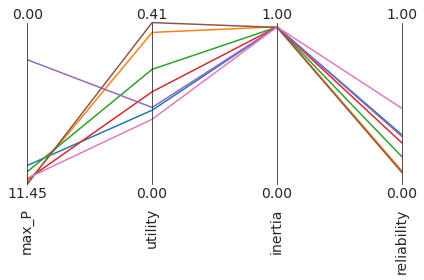

In [12]:
from ema_workbench.analysis import parcoords

data = results.loc[:, [o.name for o in model.outcomes]]

# get the minimum and maximum values as present in the dataframe
limits = parcoords.get_limits(data)

# we know that the lowest possible value for all objectives is 0
limits.loc[0, ["utility", "inertia", "reliability", "max_P"]] = 0
# inertia and reliability are defined on unit interval, so their theoretical maximum is 1
limits.loc[1, ["inertia", "reliability"]] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis("max_P")
plt.show()